In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
import pandas as pd

In [2]:
traces_train=pd.read_pickle('dataset/integrators_data_train.pickle')
results_train=pd.read_pickle('dataset/integrators_outputs_train.pickle')

traces_test=pd.read_pickle('dataset/integrators_data_test.pickle')
results_test=pd.read_pickle('dataset/integrators_outputs_test.pickle')

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(output_size, 1)
        self.sig = nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.fc(output)
        output = self.sig(output)[0]
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
def train(trace,result,nn,learning_rate,loss_function):
    hidden = nn.initHidden()
    nn.zero_grad()
    for i in range(len(trace)):
        output, hidden = nn(trace[i], hidden)
    loss = loss_function(output, result)
    loss.backward()
    for p in nn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [5]:
n_iters = 10000
print_every = 500
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
loss_function = nn.BCELoss()
n_hidden = 10
rnn = RNN(traces_train[0].size(2),n_hidden,1)

In [6]:
traces_train[0]

tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0032e+01,
          1.3626e+02, 3.4512e-01, 0.0000e+00, 1.0921e-01]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 3.1549e+00, 4.7238e+01]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0032e+01,
          1.3626e+02, 3.5000e+00, 0.0000e+00, 1.3817e-01]]])

In [7]:
losses=[]
for iter in range(1, n_iters + 1):
    index = np.random.randint(len(traces_train))
    trace, result = traces_train[index], results_train[index]
    output, loss = train(trace,result,rnn,learning_rate,loss_function)
    losses.append(loss)
    if iter % print_every == 0:
        print(output, result, loss)

tensor([0.4538], grad_fn=<SelectBackward0>) tensor([0.]) 0.6047884821891785
tensor([0.2821], grad_fn=<SelectBackward0>) tensor([0.]) 0.3314201831817627
tensor([0.0009], grad_fn=<SelectBackward0>) tensor([0.]) 0.0009466888732276857
tensor([9.2255e-05], grad_fn=<SelectBackward0>) tensor([0.]) 9.225923713529482e-05
tensor([0.9992], grad_fn=<SelectBackward0>) tensor([1.]) 0.00082353875041008
tensor([0.9995], grad_fn=<SelectBackward0>) tensor([1.]) 0.0004874463484156877
tensor([8.4515e-06], grad_fn=<SelectBackward0>) tensor([0.]) 8.451487701677252e-06
tensor([1.0000], grad_fn=<SelectBackward0>) tensor([1.]) 5.841272468387615e-06
tensor([1.0000], grad_fn=<SelectBackward0>) tensor([1.]) 7.271793037944008e-06
tensor([3.7365e-06], grad_fn=<SelectBackward0>) tensor([0.]) 3.736550297617214e-06
tensor([4.0360e-06], grad_fn=<SelectBackward0>) tensor([0.]) 4.035991423734231e-06
tensor([2.7222e-06], grad_fn=<SelectBackward0>) tensor([0.]) 2.722249291764456e-06
tensor([1.8151e-06], grad_fn=<SelectBack

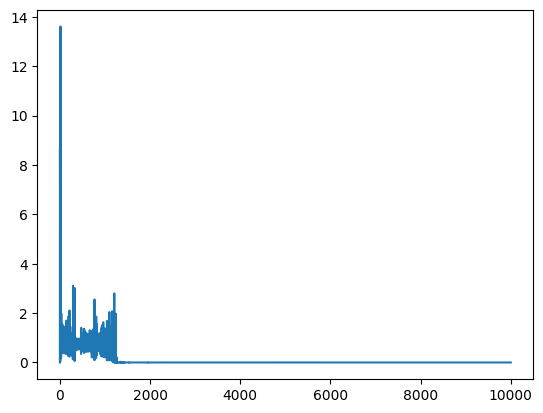

In [8]:
plt.plot(range(len(losses)),losses)

In [9]:
def evaluate(nn,trace,result):
  hidden = rnn.initHidden()
  for i in range(len(trace)):
      output, hidden = nn(trace[i], hidden)
      if output>0.5:
         output=1
      else:
         output=0
  return output==result

correct=0
for i in range(len(traces_test)):
  correct+=evaluate(rnn,traces_test[i],results_test[i])

print(correct/len(traces_test))

tensor([1.])
